In [146]:

%matplotlib inline
import pandas as pd
import numpy as np

# vectorizer
from sklearn.feature_extraction.text import CountVectorizer,HashingVectorizer,TfidfVectorizer,TfidfTransformer

# our classifiers
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier,RidgeClassifier


import os,codecs
import nltk
import string
from nltk.corpus import stopwords

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV

import re

In [82]:
baseDirectory = "./"

trainingDir = baseDirectory + "20news-bydate-train/"
testDir = baseDirectory + "20news-bydate-test/"

categories = os.listdir(trainingDir)
categories = [filename for filename in categories
                           if os.path.isdir(trainingDir + filename)]


In [83]:
def strip_header(text):

    before, blankline, after = text.partition('\n\n')
    return after

In [84]:
def stop_word(text):
    stopwords = nltk.corpus.stopwords.words('english')
    stopwords += string.lowercase[:]   
    content = [w for w in text if w not in stopwords]
    return content

# Data Preprocessing

In [134]:
def make_xy(dir, categories):
    X=[]
    Y=[]
    filesPerCat={}
    fileStats =[]
    for ind,category in enumerate(categories):
        currentdir = dir + category
        files = os.listdir(currentdir)
        filesPerCat[category] = len(files)
        for file in files:
            f = codecs.open(currentdir + '/' + file, 'r', 'iso8859-1')
            content = f.read().lower()      
        
            sen = nltk.tokenize.sent_tokenize(content)   
            #sen_no_punctuation = re.sub("[^a-zA-Z]"," ", str(sen))
            sen_no_punctuation = str(sen).translate(None,string.punctuation)
           
            tokens_no_sw = stop_word(nltk.tokenize.word_tokenize(sen_no_punctuation)) 
                     
            X.append(' '.join(tokens_no_sw))           
            Y.append(ind)
            
            fileStats.append([len(sen),len(tokens_no_sw)])
            
    return X,Y,filesPerCat,fileStats 

# Vectorization - Create X,Y arrays for train and test data

In [160]:
X_train_data,Y_train_data,trainFilesPerCat,trainFileStats = make_xy(trainingDir, categories)
X_test_data,Y_test_data, testFilesPerCat,testFileStats  = make_xy(testDir, categories)

vectorizer = TfidfVectorizer(max_df=0.5,sublinear_tf=True,stop_words='english')
X_train = vectorizer.fit_transform(X_train_data)
X_test = vectorizer.transform(X_test_data)

Y_train =np.array(Y_train_data)
Y_test = np.array(Y_test_data)


In [163]:

X_train

<11314x259541 sparse matrix of type '<type 'numpy.float64'>'
	with 1305864 stored elements in Compressed Sparse Row format>

# Number of train and test files per category

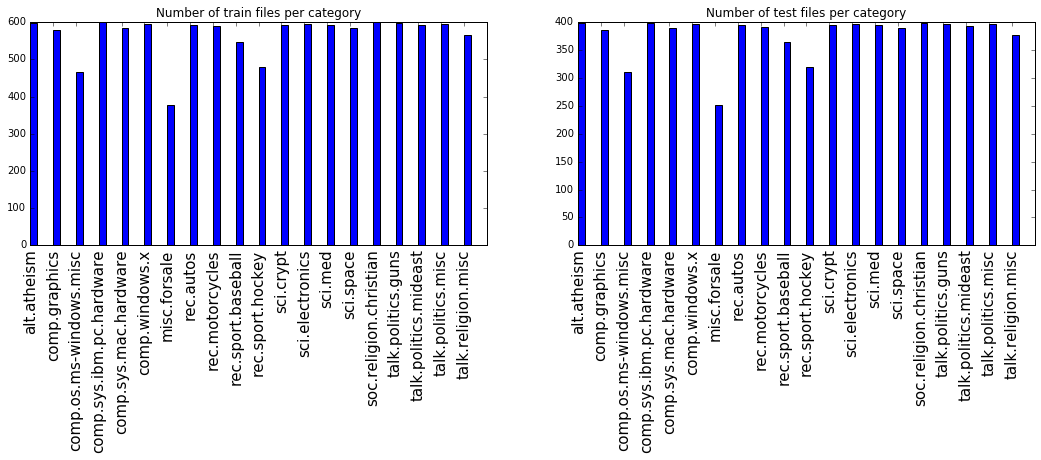

In [88]:
fig,axes = plt.subplots(1,2 ,figsize = (18,4))

plt.axes(axes[0])
x= range(len(categories))
y = trainFilesPerCat.values()
plt.bar(x,y,width=0.3,alpha=1)
axes[0].set_xticks(x)
plt.setp(axes[0].set_xticklabels(categories),rotation=90,fontsize=15)
axes[0].set_title('Number of train files per category')

plt.axes(axes[1])
y = testFilesPerCat.values()
plt.bar(x,y,width= 0.3)
axes[1].set_xticks(x)
plt.setp(axes[1].set_xticklabels(categories),rotation=90,fontsize=15)
axes[1].set_title('Number of test files per category')
plt.show()

# Histogram of sentence and word counts per file

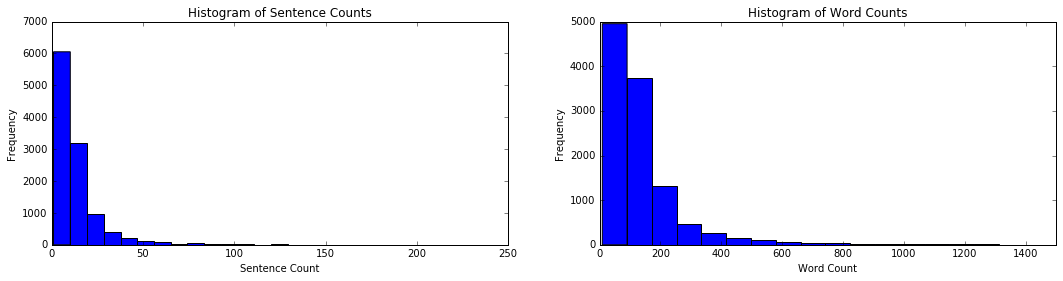

Max word count: 8155 Min word count: 9 Median word count: 100.0


In [89]:
#Histogram of Sentence counts
trainFileStats = pd.DataFrame(trainFileStats)  
sentencesPerFile = trainFileStats[0]
wordsPerFile = trainFileStats[1]
fig,axes = plt.subplots(1,2,figsize = (18,4))

plt.axes(axes[0])
plt.hist(sentencesPerFile,bins=100)
axes[0].set_xlim([0,250])
axes[0].set_xlabel('Sentence Count')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Histogram of Sentence Counts')

plt.axes(axes[1])
plt.hist(wordsPerFile,bins=100)
axes[1].set_xlim([0,1500])
axes[1].set_xlabel('Word Count')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Histogram of Word Counts')
plt.show()
print 'Max word count:',np.max(wordsPerFile),'Min word count:',np.min(wordsPerFile),'Median word count:',np.median(wordsPerFile)


# Total words across whole training data

In [90]:
# After removing stop words and punctuation
tdict={}
for i in range(len(X_train_data)):
    tokens = X_train_data[i].split()
    for t in tokens:
       
            if t not in tdict:
                tdict[t] = 1
            else:
                tdict[t] = tdict[t] + 1
word_count = pd.DataFrame.from_dict(tdict,orient='index')       
word_count.columns = ['count']
word_count = word_count.sort_values('count',ascending=False)

word_count.shape        

(259744, 1)

# Top 100 word counts plot

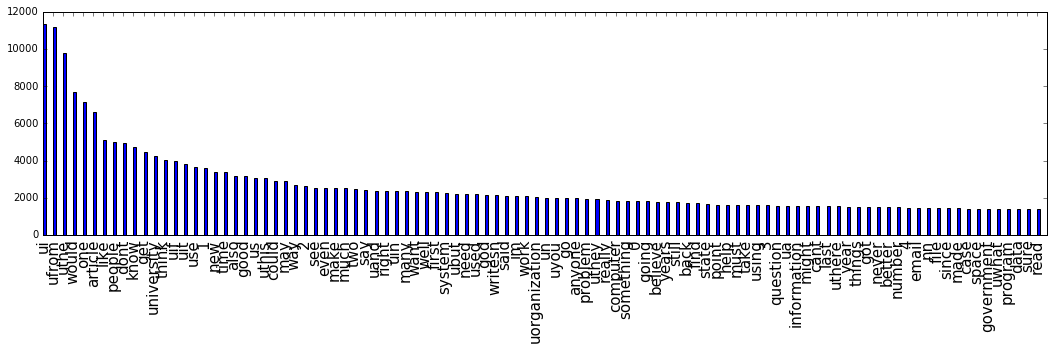

In [141]:


x = range(100)
y = word_count.head(100)['count']

fig,axes = plt.subplots(1,figsize = (18,4))
plt.bar(x,y,width= 0.3)
axes.set_xticks(x)
xtickname = axes.set_xticklabels(word_count.index[0:100])
plt.setp(xtickname,rotation = 90,fontsize = 15)
plt.show()

# Classifiers

In [164]:

clf = MultinomialNB().fit(X_train,Y_train)
print "Training data Accuracy:", (100 * clf.score(X_train, Y_train)),"%"
print "Test data Accuracy:", (100 * clf.score(X_test, Y_test)),"%"


Training data Accuracy: 96.9948736079 %
Test data Accuracy: 80.8815719596 %


In [131]:

rf_clf = RandomForestClassifier().fit(X_train,Y_train)
print "Training data Accuracy:", (100 * rf_clf.score(X_train, Y_train)),"%"
print "Test data Accuracy:", (100 * rf_clf.score(X_test, Y_test)),"%"


Training data Accuracy: 99.8055506452 %
Test data Accuracy: 61.1524163569 %


In [159]:
#svm_clf = SGDClassifier(alpha=0.0001,loss='modified_huber',n_iter=50).fit(X_train,Y_train)
#svm_clf = SVC(kernel='linear',C=1).fit(X_train,Y_train)- slowest of all
svm_clf = LinearSVC().fit(X_train,Y_train)# - aLways give global minima
print "Training data Accuracy:", (100 * svm_clf.score(X_train, Y_train)),"%"
print "Test data Accuracy:", (100 * svm_clf.score(X_test, Y_test)),"%"


Training data Accuracy: 99.9823227859 %
Test data Accuracy: 84.9707912905 %


# Top 10 features for all classes

In [112]:
def get_top10(vectorizer, clf, categories):
    featureWeight = {}
    """Get features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
   
    for i, cat in enumerate(categories):
        top10 = np.argsort(clf.coef_[i])[-10:]
        featureWeight[cat] = [[feature_names[j] for j in top10],vectorizer.idf_[top10]]
        print cat,':'," ".join(feature_names[j] for j in top10)
    return featureWeight   

featureWeight =get_top10(vectorizer,clf,categories)      
featureWeight = pd.DataFrame(featureWeight)

alt.atheism : islam islamic dont ui morality article people keith atheists god
comp.graphics : program looking file files university ui ufrom 3d image graphics
comp.os.ms-windows.misc : university ufrom use driver files ui 31 dos file windows
comp.sys.ibm.pc.hardware : pc disk ufrom bus controller ui ide scsi card drive
comp.sys.mac.hardware : scsi monitor simms ufrom centris quadra drive ui apple mac
comp.windows.x : internetnlines xterm application x11r5 widget ui ufrom motif server window
misc.forsale : sell interested condition email shipping new university ufrom offer sale
rec.autos : dealer like uthe oil engine ufrom article ui cars car
rec.motorcycles : like ufrom bmw ride motorcycle bikes article ui dod bike
rec.sport.baseball : ui ufrom runs article games game players team year baseball
rec.sport.hockey : university cup games leafs players play nhl game hockey team
sci.crypt : algorithm uthe nsa crypto government keys encryption chip clipper key
sci.electronics : like need uni

In [145]:
a= pd.DataFrame({'Feature': vectorizer.get_feature_names(),'Weight': vectorizer.idf_.tolist()})
a= a.sort_values('Weight',ascending=False)


# Top 10 features barplot

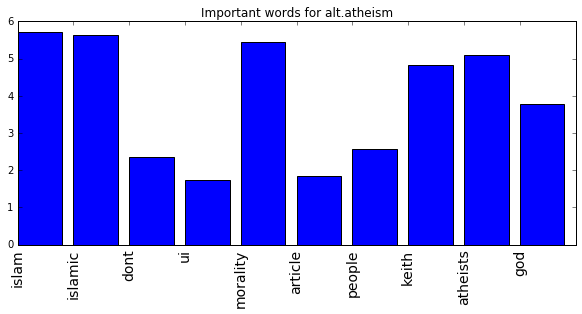

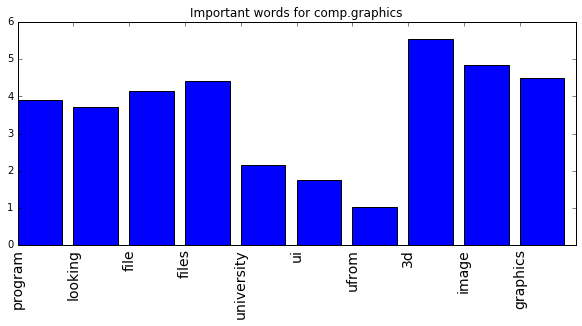

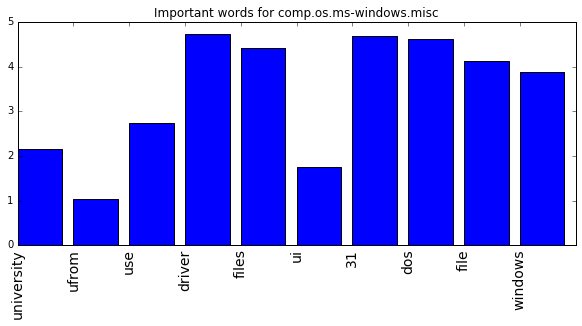

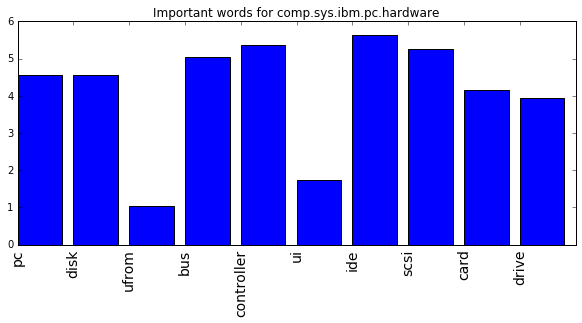

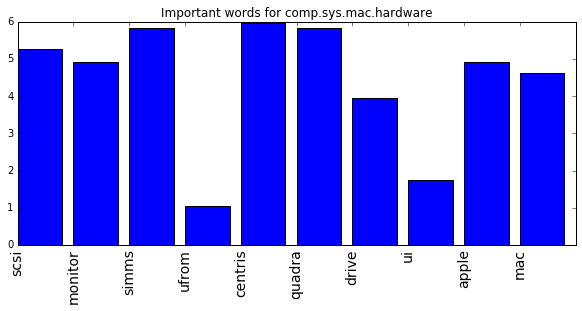

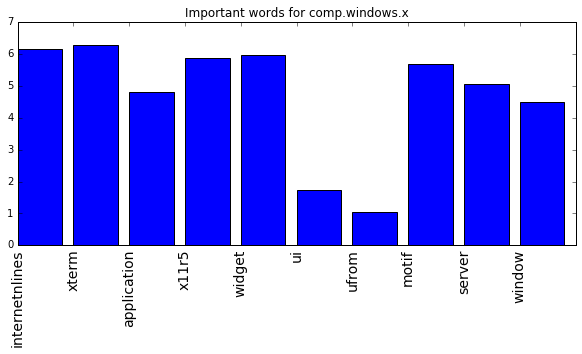

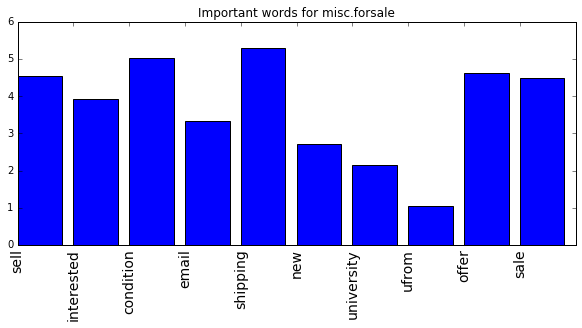

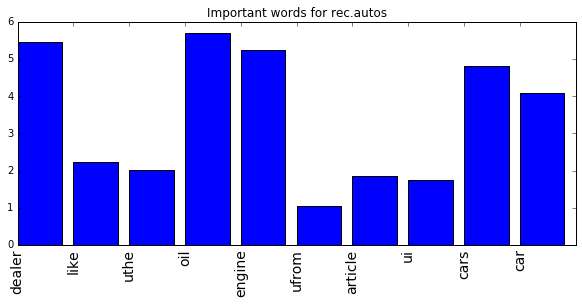

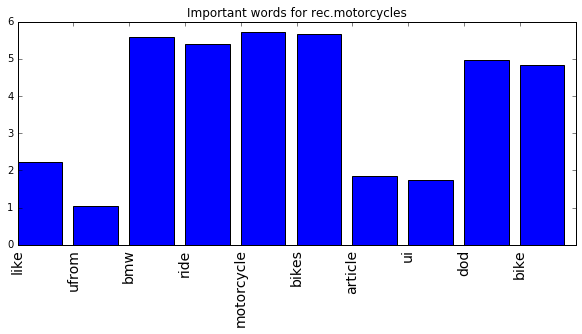

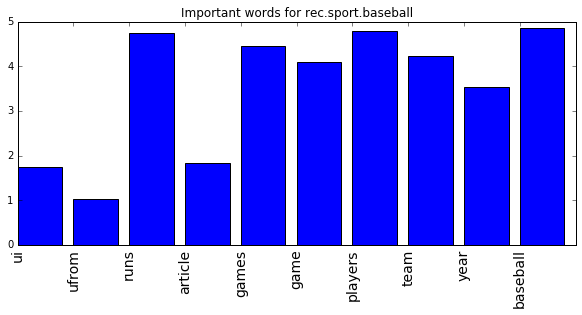

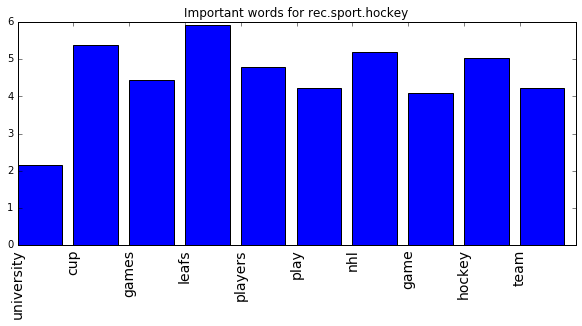

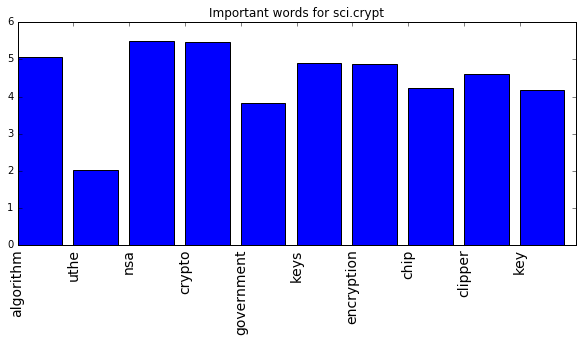

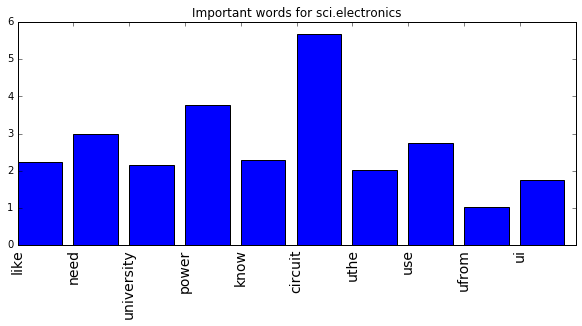

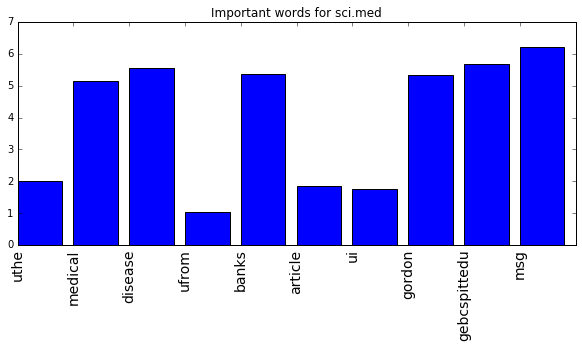

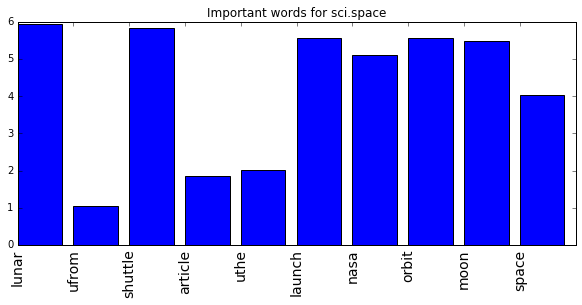

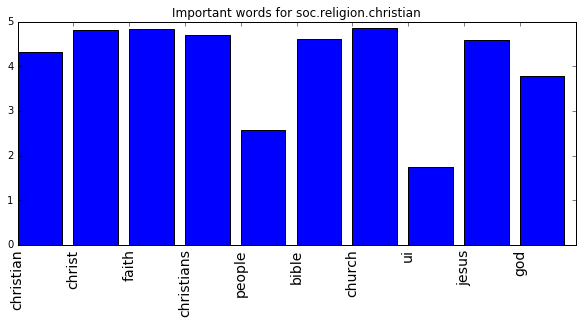

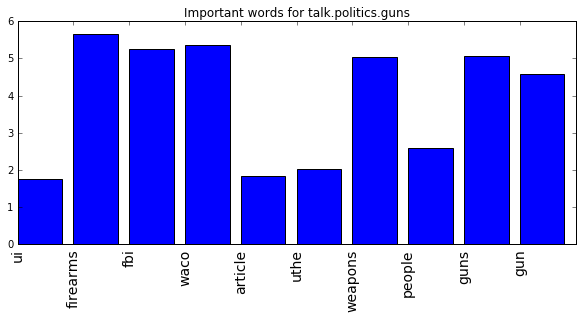

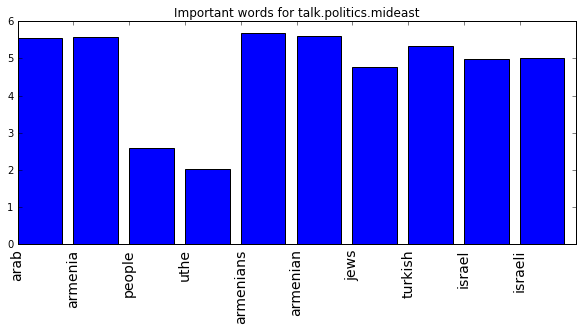

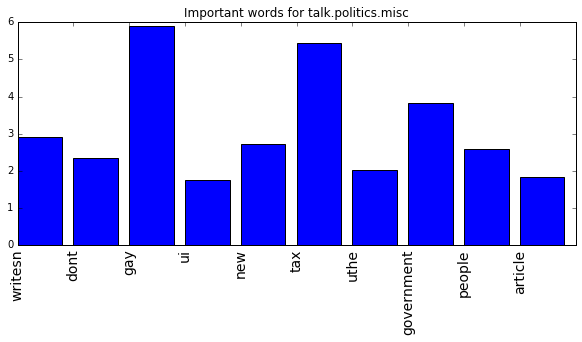

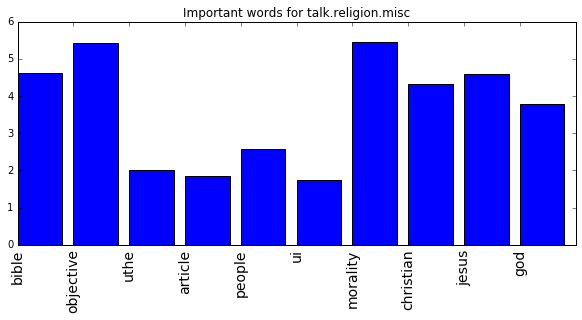

In [143]:
def feature_barplot(category,features,weights):
    
    fig,axes = plt.subplots(1, figsize= (10,4))
    x = range(len(features))
    y = weights
    plt.bar(x,y)
    axes.set_xticks(x)
    axes.set_title("Important words for " + cat)
    xName = axes.set_xticklabels(features)
    plt.setp(xName,rotation = 90,fontsize=14)
    plt.show()


for cat in categories:
    features = featureWeight[cat][0]
    weights  = featureWeight[cat][1]
    feature_barplot(cat,features,weights)

# Finding best parameters using gridsearch

In [121]:

nb_clf = MultinomialNB()
pipe = Pipeline([('vect', CountVectorizer(stop_words = 'english',min_df=3)),('tfidf', TfidfTransformer()),('clf', nb_clf)])
parameters = {'vect__ngram_range': [(1, 1), (1, 2)], 'tfidf__use_idf': [True, False],'clf__alpha': [0.05,0.1,0.2,0.5]}
gs_nb_clf = GridSearchCV(pipe, parameters, n_jobs=-1)
gs_nb_clf = gs_nb_clf.fit(X_train_data, Y_train_data)

print "Best paramters for Naive bayes are:", gs_nb_clf.best_params_
print "Training data Accuracy:", (100 * gs_nb_clf.score(X_train_data, Y_train_data)),"%"
print "Test data Accuracy:", (100 * gs_nb_clf.score(X_test_data, Y_test_data)),"%"



Best paramters for Naive bayes are: {'vect__ngram_range': (1, 1), 'tfidf__use_idf': True, 'clf__alpha': 0.05}
Training data Accuracy: 99.3282658653 %
Test data Accuracy: 83.6431226766 %


In [122]:

svm_clf = LinearSVC()
pipe = Pipeline([('vect', CountVectorizer(stop_words = 'english',min_df=5)),('tfidf', TfidfTransformer()),('clf', svm_clf)])
parameters = {'vect__ngram_range': [(1, 1), (1, 2)], 'tfidf__use_idf': (True, False),'clf__C': (0.1,1,10),'clf__tol':(.1,.01,.001)}
gs_svm_clf = GridSearchCV(pipe, parameters, n_jobs=-1)
gs_svm_clf = gs_svm_clf.fit(X_train_data, Y_train_data)
print "Best paramters for SVM are:", gs_svm_clf.best_params_
print "Training data Accuracy:", (100 * gs_svm_clf.score(X_train_data, Y_train_data)),"%"
print "Test data Accuracy:", (100 * gs_svm_clf.score(X_test_data, Y_test_data)),"%"


Best paramters for SVM are: {'vect__ngram_range': (1, 2), 'clf__tol': 0.01, 'clf__C': 1, 'tfidf__use_idf': True}
Training data Accuracy: 99.9027753226 %
Test data Accuracy: 83.0855018587 %


In [123]:
rf_clf = RandomForestClassifier()

pipe = Pipeline([('vect', CountVectorizer(stop_words = 'english',min_df=5)),('tfidf', TfidfTransformer()),('clf', rf_clf)])
parameters = {'vect__ngram_range': [(1, 1), (1, 2)], 'tfidf__use_idf': [True, False],'clf__n_estimators': [5,10,20,30],'clf__max_depth':[5,10,20,50]}
gs_rf_clf = GridSearchCV(pipe, parameters, n_jobs=-1)
gs_rf_clf = gs_rf_clf.fit(X_train_data, Y_train_data)

print "Best paramters for RF are:", gs_rf_clf.best_params_
print "Training data Accuracy:", (100 * gs_rf_clf.score(X_train_data, Y_train_data)),"%"
print "Test data Accuracy:", (100 * gs_rf_clf.score(X_test_data, Y_test_data)),"%"

Best paramters for RF are: {'vect__ngram_range': (1, 1), 'clf__max_depth': 50, 'tfidf__use_idf': True, 'clf__n_estimators': 30}
Training data Accuracy: 91.4972600318 %
Test data Accuracy: 67.5252257037 %


In [147]:
clf1 = MultinomialNB(alpha = 0.05)
clf2 = RandomForestClassifier(n_estimators = 30,max_depth=50)
clf3 = SGDClassifier(alpha=0.0001,loss='modified_huber',n_iter=50)

clf4 = SGDClassifier(loss='modified_huber',alpha=0.001,n_iter=100)
clf5 = MultinomialNB(alpha = .08)
clf6 = RandomForestClassifier(n_estimators = 50,max_depth=60)

clfs = [clf1,clf2,clf3]#,clf4,clf5,clf6]


In [148]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
import numpy as np
import operator

class EnsembleClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, clfs, weights=None):
        self.clfs = clfs
        self.weights = weights

    def fit(self, X, y):
        self.clfs_=[]
        for clf in self.clfs:
            self.clfs_.append(clf.fit(X, y))
        return self
    
    def predict(self, X):
        
        maj_vote = np.argmax(self.predict_proba(X),axis=1)

        return maj_vote

    def predict_proba(self, X):

        probas = np.asarray([clf.predict_proba(X)for clf in  self.clfs_])
        avg_proba = np.average(probas,  axis=0, weights=self.weights)
        return avg_proba

In [149]:
from sklearn import cross_validation
np.random.seed(123)
eclf = EnsembleClassifier(clfs, weights=[1,1,1])

for clf, label in zip([clf1, clf2, clf3, eclf], ['Naive Bayes', 'Random Forest', 'SVM', 'Ensemble']):

    scores = cross_validation.cross_val_score(clf, X_train, Y_train, cv=5,scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))


Accuracy: 0.88 (+/- 0.02) [Naive Bayes]
Accuracy: 0.71 (+/- 0.03) [Random Forest]
Accuracy: 0.90 (+/- 0.02) [SVM]
Accuracy: 0.90 (+/- 0.02) [Ensemble]


In [150]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label in zip([clf1, clf2, clf3, eclf], ['Naive Bayes', 'Random Forest', 'SVM', 'Ensemble']):

    Y_pred = clf.fit(X_train,Y_train).predict(X_test)
    corr = np.where(Y_pred==Y_test)
    accuracy = float(len(corr[0]))/len(Y_test)
    print "Accuracy: %0.2f [%s]" , accuracy, label


Accuracy: %0.2f [%s] 0.835767392459 Naive Bayes
Accuracy: %0.2f [%s] 0.656664896442 Random Forest
Accuracy: %0.2f [%s] 0.849442379182 SVM
Accuracy: %0.2f [%s] 0.857142857143 Ensemble
